In [1]:
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline, CustomFilter, CustomFactor
from quantopian.pipeline.data import Fundamentals 
from quantopian.pipeline.data import factset
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.classifiers.fundamentals import Sector  
from quantopian.pipeline.classifiers.morningstar import Sector 
from quantopian.pipeline.filters import QTradableStocksUS, Q1500US, Q500US
from quantopian.pipeline.filters.eventvestor import IsAnnouncedAcqTarget
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.data.psychsignal import aggregated_twitter_withretweets_stocktwits as st
from quantopian.pipeline.data.zacks import EarningsSurprises
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import Latest
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats.mstats import winsorize
from zipline.utils.numpy_utils import ( repeat_first_axis, repeat_last_axis )

In [2]:
from quantopian.pipeline.factors import ( CustomFactor, BusinessDaysSincePreviousEvent, 
                                         BusinessDaysUntilNextEvent, SimpleMovingAverage, 
                                         AverageDollarVolume, Returns, RSI, 
                                         RollingLinearRegressionOfReturns, RollingSpearmanOfReturns, 
                                         AnnualizedVolatility, Returns, DailyReturns)

In [3]:
import talib
import pandas as pd
import numpy as np
from time import time

In [45]:
import alphalens as al
import pyfolio as pf
from scipy import stats
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.svm import SVC, OneClassSVM, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model, decomposition, ensemble, preprocessing, isotonic, metrics

In [5]:
from quantopian.pipeline.data.quandl import fred_usdontd156n as libor
from sklearn.metrics import classification_report

In [6]:
WIN_LIMIT = 0.0

In [7]:
def preprocess(a):
    
    a = np.nan_to_num(a - np.nanmean(a))
    
    a = winsorize(a, limits=[WIN_LIMIT,WIN_LIMIT])

    return preprocessing.scale(a)

In [9]:
has_data = (morningstar.income_statement.gross_profit.latest.notnull()
            & morningstar.balance_sheet.total_assets.latest.notnull()
            & morningstar.valuation_ratios.book_value_yield.latest.notnull()
            & morningstar.valuation.market_cap.latest.notnull()
            & morningstar.asset_classification.morningstar_sector_code.latest.notnull()
)

In [10]:
is_tradeable = (QTradableStocksUS()
                & has_data )

In [11]:
class GP_to_A(CustomFactor):
    
    inputs = [morningstar.income_statement.gross_profit, morningstar.balance_sheet.total_assets]
    window_length = 1
    
    def compute(self, today, assets, out, gross_profit, total_assets):       
        out[:] = gross_profit[-1] / total_assets[-1]
                
def make_pipeline():

    pipe = Pipeline(
        columns = {
            'GP_to_A' : GP_to_A(),
            'B_to_M' : morningstar.valuation_ratios.book_value_yield.latest,
            'Market_Cap' : morningstar.valuation.market_cap.latest,
            'sector' : morningstar.asset_classification.morningstar_sector_code.latest,
        },
        screen=is_tradeable
    )
    return pipe

In [30]:
pipe = make_pipeline()

In [31]:
start_date = '2018-06-01'
end_date = '2018-06-01'

start_timer = time()
data = run_pipeline(pipe, start_date, end_date)
end_timer = time()

print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

Time to run pipeline 0.81 secs


####Measure of Quality = Gross Profitability-to-Assets (GP/A) | Measure of Value = Book-to-Market (B/M) & Market Cap

In [33]:
assets = data.index.levels[1]
num_assets = len(data.index.levels[1])
print 'Number of Stocks:', num_assets
data.index=data.index.droplevel(0)
data.head()

Number of Stocks: 1872


,B_to_M,GP_to_A,Market_Cap,sector
Equity(2 [ARNC]),0.5958,0.037159,8.748918e+09,310
Equity(24 [AAPL]),0.1377,0.063733,9.215884e+11,311
Equity(41 [ARCB]),0.5510,0.305436,1.207715e+09,310
Equity(52 [ABM]),0.7397,0.041875,1.915155e+09,310
Equity(53 [ABMD]),0.0399,0.183549,1.728275e+10,206


#####Quality is usually negatively correlated with value. High quality stocks tend to have lower book-to-market ratios. One way to show this is to divide stocks into 10 deciles based on GP/A, and look at the average B/M for each GP/A decile. The results are monotonic in deciles.

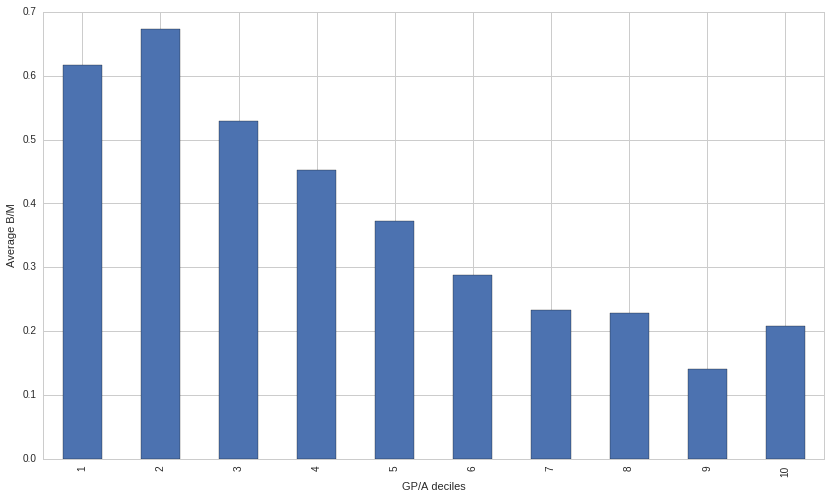

In [34]:
data=data.dropna()
data['decile']=pd.qcut(data['GP_to_A'],10,labels=False)+1
quantile_averages=data.groupby('decile')['B_to_M'].apply(lambda x: x.mean())
quantile_averages.plot(kind='bar')
plt.xlabel('GP/A deciles')
plt.ylabel('Average B/M');

#####compute z-scores for gross profitability-to-assets and for book-to-market, which reduces the influence of outliers and allows for easier interpretation of regression coefficients.

In [35]:
data['gp_z']=data.groupby('sector')['GP_to_A'].transform(lambda x: (x-x.mean())/x.std())
data['bm_z']=data.groupby('sector')['B_to_M'].transform(lambda x: (x-x.mean())/x.std())
data['MC_demean']=data.groupby('sector')['Market_Cap'].transform(lambda x: x.mean())
data=data.dropna()
data.head()

,B_to_M,GP_to_A,Market_Cap,sector,decile,gp_z,bm_z,MC_demean
Equity(2 [ARNC]),0.5958,0.037159,8.748918e+09,310,3,-0.584199,0.624020,1.116970e+10
Equity(24 [AAPL]),0.1377,0.063733,9.215884e+11,311,6,-0.551088,-0.456353,2.053919e+10
Equity(41 [ARCB]),0.5510,0.305436,1.207715e+09,310,10,4.230668,0.490829,1.116970e+10
Equity(52 [ABM]),0.7397,0.041875,1.915155e+09,310,4,-0.499556,1.051837,1.116970e+10
Equity(53 [ABMD]),0.0399,0.183549,1.728275e+10,206,10,1.387207,-0.570505,1.309524e+10


In [36]:
results = sm.OLS(data['bm_z'],sm.add_constant(data['gp_z'])).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   bm_z   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     142.0
Date:                Sun, 21 Apr 2019   Prob (F-statistic):           1.33e-31
Time:                        23:58:33   Log-Likelihood:                -2582.2
No. Observations:                1872   AIC:                             5168.
Df Residuals:                    1870   BIC:                             5180.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       8.847e-17      0.022   3.98e-15      1.000        -0.044     0.044
gp_z          -0.2656      0.022    -11.915      0.000        -0.309    -0.222
==============================================================================
Omnibus:                      795.973   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           214544.049
Skew:                          -0.756   Prob(JB):                         0.00
Kurtosis:                      55.424   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

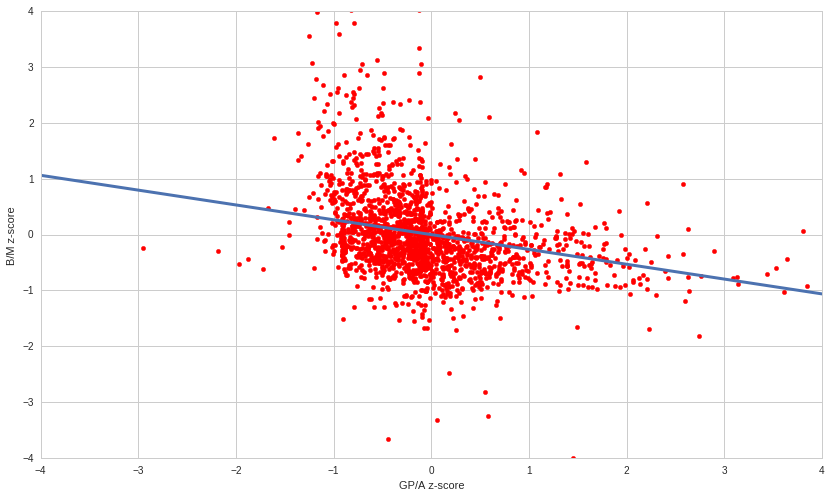

In [37]:
plt.scatter(data['gp_z'],data['bm_z'],marker='o',color='r')
plt.ylim([-4,4])
plt.xlim([-4,4])
plt.ylabel('B/M z-score')
plt.xlabel('GP/A z-score')
X_plot = np.linspace(-4,4,100)
plt.plot(X_plot, X_plot*results.params[1] + results.params[0],linewidth=3);

Novy-Marx claims that GP/A is also correlated to Market Cap, and therefore a portfolio of high GP/A stocks will be more liquid and produce a higher Fama-French three factor alpha because of its negative loading on size.

I was not able to find a positive correlation between GP/A and Market Cap for the recent period

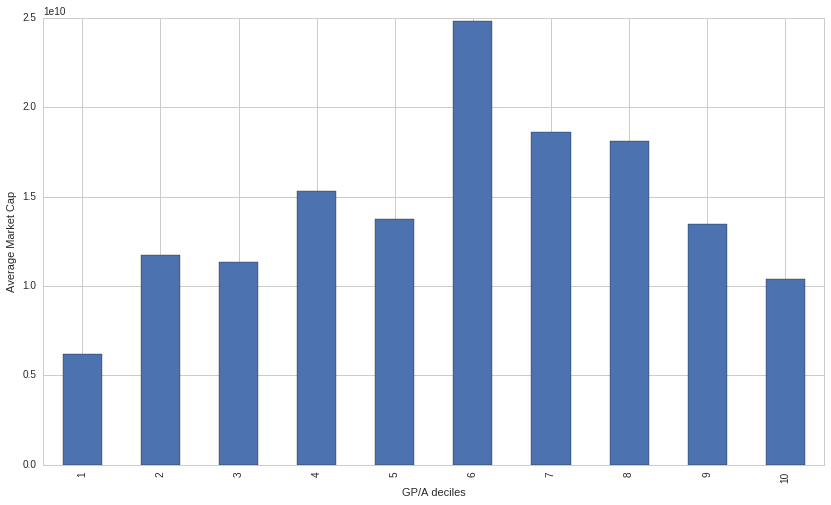

In [38]:
quantile_averages=data.groupby('decile')['Market_Cap'].apply(lambda x: x.mean())
quantile_averages.plot(kind='bar')
plt.xlabel('GP/A deciles')
plt.ylabel('Average Market Cap');

In [63]:
sector_names = {
     -1: 'Misc',
    101: 'Basic Mtrls',
    102: 'Consmr Cyc',
    103: 'Financial Svs',
    104: 'Real Estate',
    205: 'Consmr Def',
    206: 'Healthcare',
    207: 'Utilities',
    308: 'Comm Svs',
    309: 'Energy',
    310: 'Industrials',
    311: 'Technology' ,    
}

In [64]:
data['sector_name']=data['sector'].map(sector_names)
data.head()

,B_to_M,GP_to_A,Market_Cap,sector,decile,gp_z,bm_z,MC_demean,sector_name,GP_to_A_winsorize
Equity(2 [ARNC]),0.5958,0.037159,8.748918e+09,310,3,-0.584199,0.624020,1.116970e+10,Industrials,0.037159
Equity(24 [AAPL]),0.1377,0.063733,9.215884e+11,311,6,-0.551088,-0.456353,2.053919e+10,Technology,0.063733
Equity(41 [ARCB]),0.5510,0.305436,1.207715e+09,310,10,4.230668,0.490829,1.116970e+10,Industrials,0.305436
Equity(52 [ABM]),0.7397,0.041875,1.915155e+09,310,4,-0.499556,1.051837,1.116970e+10,Industrials,0.041875
Equity(53 [ABMD]),0.0399,0.183549,1.728275e+10,206,10,1.387207,-0.570505,1.309524e+10,Healthcare,0.183549


###The mean GP/A factor varies considerably by sector.

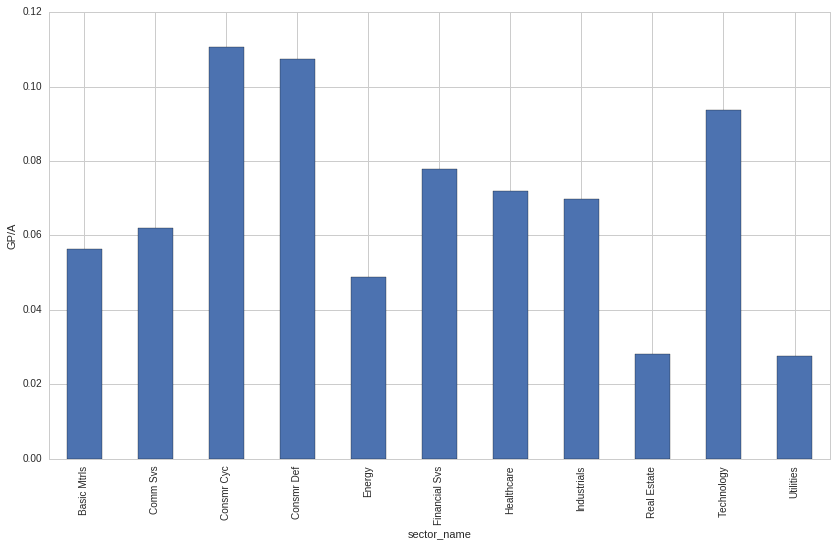

In [65]:
sector_averages=data.groupby('sector_name')['GP_to_A'].apply(lambda x: x.mean())
plt.ylabel('GP/A')
sector_averages.plot(kind='bar');

####winsorized GP/A

In [66]:
data['GP_to_A_winsorize']=scipy.stats.mstats.winsorize(data['GP_to_A'],inplace=True,limits=.002)
data.head()

,B_to_M,GP_to_A,Market_Cap,sector,decile,gp_z,bm_z,MC_demean,sector_name,GP_to_A_winsorize
Equity(2 [ARNC]),0.5958,0.037159,8.748918e+09,310,3,-0.584199,0.624020,1.116970e+10,Industrials,0.037159
Equity(24 [AAPL]),0.1377,0.063733,9.215884e+11,311,6,-0.551088,-0.456353,2.053919e+10,Technology,0.063733
Equity(41 [ARCB]),0.5510,0.305436,1.207715e+09,310,10,4.230668,0.490829,1.116970e+10,Industrials,0.305436
Equity(52 [ABM]),0.7397,0.041875,1.915155e+09,310,4,-0.499556,1.051837,1.116970e+10,Industrials,0.041875
Equity(53 [ABMD]),0.0399,0.183549,1.728275e+10,206,10,1.387207,-0.570505,1.309524e+10,Healthcare,0.183549


In [67]:
data['GP_to_A_winsorize'].describe()

count    1872.000000
mean        0.076118
std         0.069367
min        -0.011590
25%         0.031847
50%         0.059235
75%         0.098315
max         0.611861
Name: GP_to_A_winsorize, dtype: float64

###A boxplot shows how the range of GP/A also varies considerably by sector.

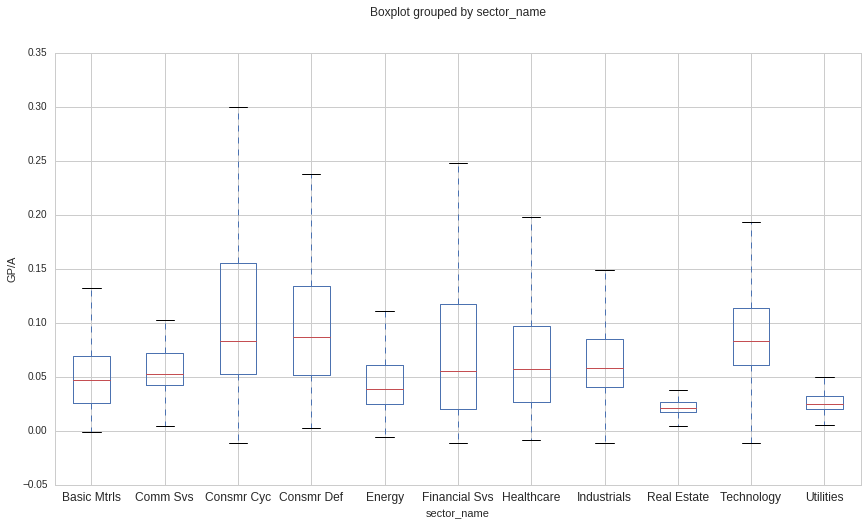

In [68]:
data.boxplot(column='GP_to_A_winsorize',by='sector_name')
plt.ylabel('GP/A')
plt.title('')
plt.ylim(-.05,0.35);